In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from sklearn.preprocessing import MinMaxScaler

# Load the 16x16 matrix from an xlsx file
file_path = "/content/tm.xlsx"
TM = pd.read_excel(file_path).iloc[:16, :16]

In [16]:
# Generate a dataset by multiplying it with a random scaling factor
n_seconds = 1501  # 0s to 1500s (inclusive)

dataset = []
for t in range(n_seconds):
    scaling_factor = np.random.uniform(0.75, 1.25, (16, 16))
    scaled_traffic = TM * scaling_factor
    dataset.append(scaled_traffic)

random_seconds = np.random.choice(n_seconds - 5, 50, replace=False)

for sec in random_seconds:
    scaling_factor = [np.random.uniform(0.1, 0.5, (16, 16)), np.random.uniform(1.5, 2, (16, 16))]
    idx = np.random.choice([0, 1])
    for i in range(5):
        dataset[sec + i] = dataset[sec + i] * scaling_factor[idx]

# Extract row 0 and column 1 values of every second --- ToR 0 to 1
data = [ToR[0][1] for ToR in dataset]

In [17]:
# Normalisation with Median
sorted_data = sorted(data)
median = sorted_data[n_seconds // 2]

data = [data / median]
data[-5:]

[array([1.06210193, 1.16067908, 1.16137019, ..., 0.89609271, 1.04177211,
        0.96920439])]

In [18]:
# Normalize the dataset
scaler = MinMaxScaler()
dataset = np.array(data).reshape(-1, 1)
dataset = scaler.fit_transform(dataset)

# Split the dataset into training and testing sets
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

In [19]:
# Create sequences and labels for training
def create_sequences(dataset, look_back = 10):
    sequences, labels = [], []
    for i in range(len(dataset) - look_back):
        sequences.append(dataset[i:i+look_back])
        labels.append(dataset[i+look_back])
    return np.array(sequences), np.array(labels)

look_back = 10  # Window size
train_sequences, train_labels = create_sequences(train_data, look_back)
test_sequences, test_labels = create_sequences(test_data, look_back)

In [20]:
# Build a Bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, input_shape=(look_back, 1))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [21]:
# Train the model
model.fit(train_sequences, train_labels, epochs=10, batch_size=32, verbose=2)

Epoch 1/10
38/38 - 6s - loss: 0.0162 - 6s/epoch - 166ms/step
Epoch 2/10
38/38 - 1s - loss: 0.0089 - 1s/epoch - 28ms/step
Epoch 3/10
38/38 - 1s - loss: 0.0085 - 1s/epoch - 32ms/step
Epoch 4/10
38/38 - 1s - loss: 0.0082 - 823ms/epoch - 22ms/step
Epoch 5/10
38/38 - 0s - loss: 0.0079 - 397ms/epoch - 10ms/step
Epoch 6/10
38/38 - 0s - loss: 0.0075 - 438ms/epoch - 12ms/step
Epoch 7/10
38/38 - 0s - loss: 0.0071 - 398ms/epoch - 10ms/step
Epoch 8/10
38/38 - 0s - loss: 0.0067 - 410ms/epoch - 11ms/step
Epoch 9/10
38/38 - 0s - loss: 0.0064 - 412ms/epoch - 11ms/step
Epoch 10/10
38/38 - 0s - loss: 0.0062 - 386ms/epoch - 10ms/step


In [22]:
# Make predictions on test data
test_predictions = model.predict(test_sequences)

# Inverse transform the predictions to the original scale
test_predictions = scaler.inverse_transform(test_predictions)
test_labels = scaler.inverse_transform(test_labels)

10/10 [==============================] - 1s 5ms/step


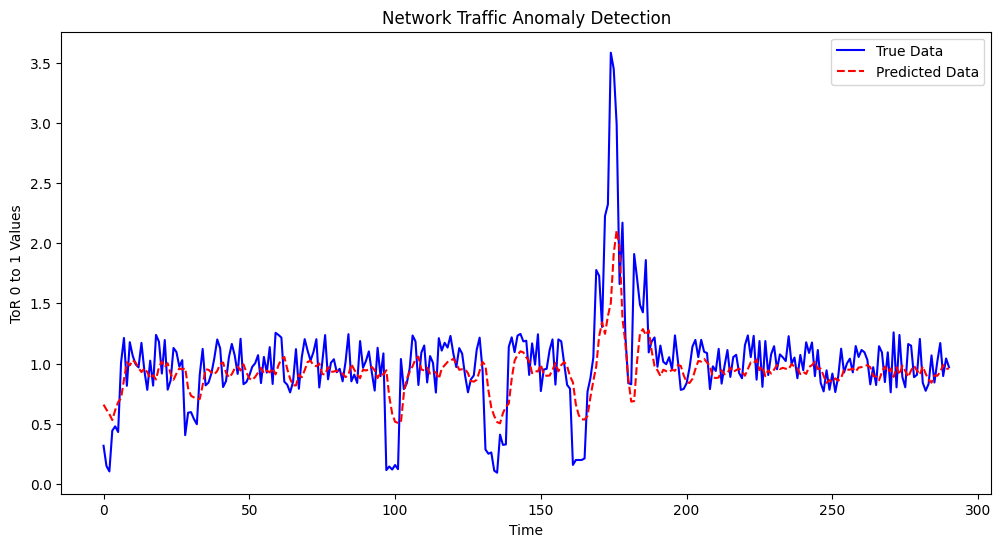

In [25]:
# Plot the test data, predicted data, and anomalies
plt.figure(figsize=(12, 6))
plt.plot(test_labels, label='True Data', color='blue')
plt.plot(test_predictions, label='Predicted Data', linestyle='--', color='red')


plt.title('Network Traffic Anomaly Detection')
plt.xlabel('Time')
plt.ylabel('ToR 0 to 1 Values')
plt.legend()
plt.show()